# 1.5 「ファインチューニング」で精度向上を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、ファインチューニングでアリとハチの画像を分類するモデルを学習します



# 学習目標

1.	PyTorchでGPUを使用する実装コードを書けるようになる
2.	最適化手法の設定において、層ごとに異なる学習率を設定したファインチューニングを実装できるようになる
3.	学習したネットワークを保存・ロードできるようになる



# 事前準備

- 1.4節で解説したAWS EC2 のGPUインスタンスを使用します


In [1]:
# パッケージのimport
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [2]:
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 False


In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size = 32

In [5]:
OUTPUT_FEATURES = 2

LEARNING_RATE = 0.001
MOMENTUM = 0.0
# WEIGHT_DECAY = 1e-3

NUM_EPOCHS = 8

# DatasetとDataLoaderを作成

In [6]:
# 1.3節で作成したクラスを同じフォルダにあるmake_dataset_dataloader.pyに記載して使用
from utils.dataloader_image_classification import (
    HymenopteraDataset,
    ImageTransform,
    make_datapath_list,
)

# アリとハチの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Datasetを作成する
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
)


# DataLoaderを作成する
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


# モデルを学習させる関数を作成

In [7]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    history = {}
    history["train"] = {}
    history["val"] = {}
    history["train"]["loss"] = []
    history["train"]["acc"] = []
    history["val"]["loss"] = []
    history["val"]["acc"] = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        # print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            # if (epoch == 0) and (phase == "train"):
            #     continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)
    return history

# 損失関数を定義

In [8]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークモデルの作成fc

In [9]:
efficientnet_models = {
    "efficientnet_b0": (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT),
    "efficientnet_b2": (models.efficientnet_b2, models.EfficientNet_B2_Weights.DEFAULT),
    "efficientnet_b4": (models.efficientnet_b4, models.EfficientNet_B4_Weights.DEFAULT),
    "efficientnet_b6": (models.efficientnet_b6, models.EfficientNet_B6_Weights.DEFAULT),
}

In [11]:
model = models.efficientnet_b0()
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
efficientnet_results = {}
for name, (model, weights) in efficientnet_models.items():
    _net = model(weights=weights)
    last_in_features = _net.classifier[-1].in_features
    _net.classifier[-1] = nn.Linear(in_features=last_in_features, out_features=OUTPUT_FEATURES)
    _net.train()
    print("Model:", name, last_in_features)

    # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
    for param in _net.parameters():
        param.requires_grad = False

    params_to_update = []
    for param in _net.classifier[-1].parameters():
        param.requires_grad = True
        params_to_update.append(param)

    optimizer = optim.SGD(
        params_to_update,
        lr=LEARNING_RATE,
        momentum=MOMENTUM,
    )
    # optimizer = optim.Adam(
    #     params_to_update,
    #     lr=LEARNING_RATE,
    #     weight_decay=WEIGHT_DECAY,
    # )

    history = train_model(
        _net, dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS
    )
    efficientnet_results[name] = history

Model: efficientnet_b0 1280
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


train Loss: 0.7156 Acc: 0.4774


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


val Loss: 0.6823 Acc: 0.5359
Epoch 2/8


100%|██████████| 8/8 [00:13<00:00,  1.75s/it]


train Loss: 0.7010 Acc: 0.5185


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


val Loss: 0.6818 Acc: 0.5294
Epoch 3/8


100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


train Loss: 0.6953 Acc: 0.5062


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


val Loss: 0.6708 Acc: 0.5752
Epoch 4/8


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


train Loss: 0.6732 Acc: 0.5844


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


val Loss: 0.6580 Acc: 0.6144
Epoch 5/8


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


train Loss: 0.6725 Acc: 0.5432


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


val Loss: 0.6478 Acc: 0.6601
Epoch 6/8


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]


train Loss: 0.6550 Acc: 0.6296


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


val Loss: 0.6400 Acc: 0.6863
Epoch 7/8


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


train Loss: 0.6442 Acc: 0.6420


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


val Loss: 0.6265 Acc: 0.7059
Epoch 8/8


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


train Loss: 0.6339 Acc: 0.6996


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/yokoya/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


val Loss: 0.6163 Acc: 0.7190


100%|██████████| 35.2M/35.2M [00:00<00:00, 37.2MB/s]


Model: efficientnet_b2 1408
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


train Loss: 0.7303 Acc: 0.4033


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


val Loss: 0.6680 Acc: 0.6209
Epoch 2/8


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


train Loss: 0.6979 Acc: 0.5432


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


val Loss: 0.6671 Acc: 0.6275
Epoch 3/8


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


train Loss: 0.6844 Acc: 0.5514


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


val Loss: 0.6609 Acc: 0.6275
Epoch 4/8


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


train Loss: 0.6686 Acc: 0.5761


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


val Loss: 0.6532 Acc: 0.6732
Epoch 5/8


100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


train Loss: 0.6650 Acc: 0.5679


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


val Loss: 0.6444 Acc: 0.6732
Epoch 6/8


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


train Loss: 0.6568 Acc: 0.6420


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


val Loss: 0.6359 Acc: 0.6993
Epoch 7/8


100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


train Loss: 0.6513 Acc: 0.6049


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


val Loss: 0.6272 Acc: 0.7255
Epoch 8/8


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


train Loss: 0.6380 Acc: 0.6214


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


val Loss: 0.6191 Acc: 0.7451


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /home/yokoya/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:04<00:00, 15.9MB/s]


Model: efficientnet_b4 1792
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:35<00:00,  4.44s/it]


train Loss: 0.6807 Acc: 0.5844


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


val Loss: 0.6959 Acc: 0.4837
Epoch 2/8


100%|██████████| 8/8 [00:34<00:00,  4.34s/it]


train Loss: 0.6738 Acc: 0.6379


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


val Loss: 0.6876 Acc: 0.5556
Epoch 3/8


100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


train Loss: 0.6772 Acc: 0.6091


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


val Loss: 0.6781 Acc: 0.6209
Epoch 4/8


100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


train Loss: 0.6764 Acc: 0.6296


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


val Loss: 0.6745 Acc: 0.6275
Epoch 5/8


100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


train Loss: 0.6736 Acc: 0.6626


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


val Loss: 0.6712 Acc: 0.6797
Epoch 6/8


100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


train Loss: 0.6750 Acc: 0.6296


100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


val Loss: 0.6704 Acc: 0.6601
Epoch 7/8


100%|██████████| 8/8 [00:34<00:00,  4.33s/it]


train Loss: 0.6663 Acc: 0.6461


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


val Loss: 0.6673 Acc: 0.6928
Epoch 8/8


100%|██████████| 8/8 [00:34<00:00,  4.35s/it]


train Loss: 0.6641 Acc: 0.7160


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


val Loss: 0.6653 Acc: 0.6928


Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /home/yokoya/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth
100%|██████████| 165M/165M [00:09<00:00, 18.4MB/s] 


Model: efficientnet_b6 2304
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [01:05<00:00,  8.18s/it]


train Loss: 0.7244 Acc: 0.3992


100%|██████████| 5/5 [00:30<00:00,  6.09s/it]


val Loss: 0.7468 Acc: 0.1895
Epoch 2/8


100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


train Loss: 0.7009 Acc: 0.5473


100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


val Loss: 0.7370 Acc: 0.2222
Epoch 3/8


100%|██████████| 8/8 [01:04<00:00,  8.00s/it]


train Loss: 0.7081 Acc: 0.4403


100%|██████████| 5/5 [00:30<00:00,  6.10s/it]


val Loss: 0.7266 Acc: 0.2810
Epoch 4/8


100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


train Loss: 0.7004 Acc: 0.5144


100%|██████████| 5/5 [00:30<00:00,  6.16s/it]


val Loss: 0.7168 Acc: 0.3137
Epoch 5/8


100%|██████████| 8/8 [01:04<00:00,  8.03s/it]


train Loss: 0.6938 Acc: 0.5103


100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


val Loss: 0.7064 Acc: 0.3660
Epoch 6/8


100%|██████████| 8/8 [01:04<00:00,  8.03s/it]


train Loss: 0.6791 Acc: 0.5556


100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


val Loss: 0.6966 Acc: 0.4314
Epoch 7/8


100%|██████████| 8/8 [01:04<00:00,  8.05s/it]


train Loss: 0.6826 Acc: 0.5267


100%|██████████| 5/5 [00:30<00:00,  6.14s/it]


val Loss: 0.6858 Acc: 0.5425
Epoch 8/8


100%|██████████| 8/8 [01:03<00:00,  7.98s/it]


train Loss: 0.6739 Acc: 0.5761


100%|██████████| 5/5 [00:30<00:00,  6.16s/it]

val Loss: 0.6759 Acc: 0.5948


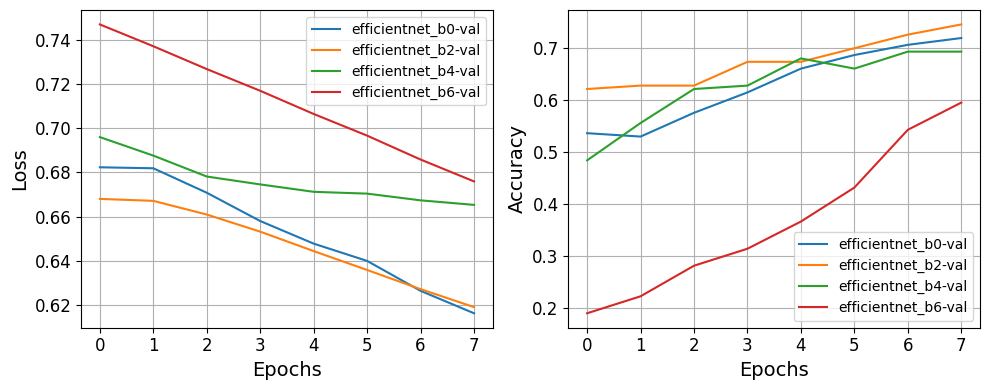

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for model in efficientnet_results.keys():
    # for phase in efficientnet_results[model].keys():
    for phase in ['val']:
        axes[0].plot(
            range(len(efficientnet_results[model][phase]["loss"])),
            efficientnet_results[model][phase]["loss"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[0].set_xlabel("Epochs", size=14)
axes[0].set_ylabel("Loss", size=14)
axes[0].tick_params(labelsize=12)
axes[0].grid()
axes[0].legend()

for model in efficientnet_results.keys():
    # for phase in efficientnet_results[model].keys():
    for phase in ['val']:
        axes[1].plot(
            range(len(efficientnet_results[model][phase]["acc"])),
            efficientnet_results[model][phase]["acc"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[1].set_xlabel("Epochs", size=14)
axes[1].set_ylabel("Accuracy", size=14)
axes[1].tick_params(labelsize=12)
axes[1].grid()
axes[1].legend()
plt.show()

# 学習したネットワークを保存・ロード

In [ ]:
# # PyTorchのネットワークパラメータの保存
# save_path = "./weights_fine_tuning.pth"
# torch.save(net.state_dict(), save_path)

In [ ]:
# # PyTorchのネットワークパラメータのロード
# load_path = "./weights_fine_tuning.pth"
# load_weights = torch.load(load_path)
# net.load_state_dict(load_weights)

# # GPU上で保存された重みをCPU上でロードする場合
# load_weights = torch.load(load_path, map_location={"cuda:0": "cpu"})
# net.load_state_dict(load_weights)

以上